# Homework 5: Neural Networks (Extra credit - 25 points)

## Question : Multi-layer perceptron training using backpropagation

In this part of the homework you will implement a multi-layer perceptron model and train it using the backpropagation algorithm. 

Import the packages. Please do not import any other packages. 

In [21]:
import os
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import numpy as np
%matplotlib inline

### Loading and splitting the data
We will load and work with the half moons data set from sklearn and train a multi-layer perceptron to distinguish between the two classes

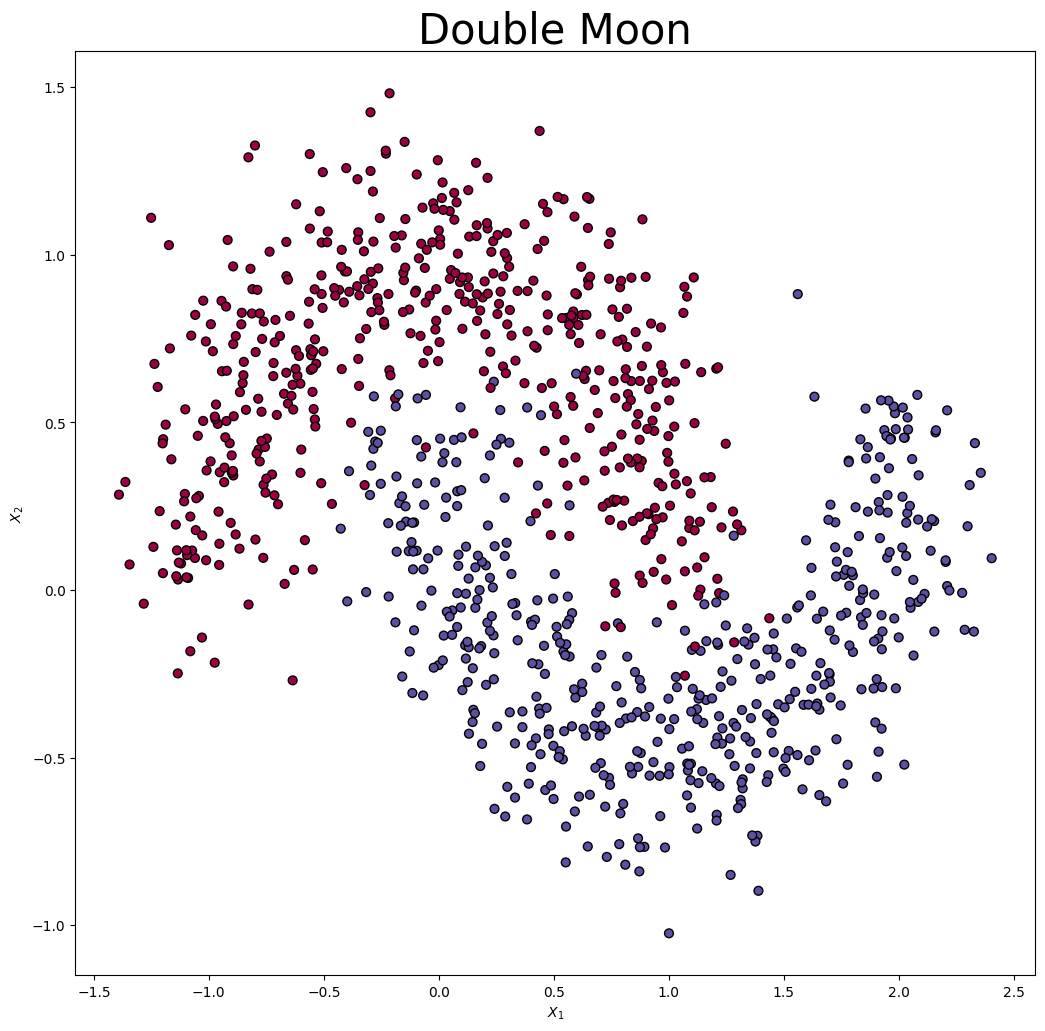

In [22]:
# number of samples in the data set
N_SAMPLES = 1000
# ratio between training and test sets
TEST_SIZE = 0.1

# Double moon dataset
X, y = make_moons(n_samples = N_SAMPLES, noise=0.2, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

def make_plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None, dark=False):
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 1, cmap=cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black')
    if(file_name):
        plt.savefig(file_name)
        plt.close()
        
make_plot(X, y, "Double Moon")

### P2.a: Create and initialize the multi-layer perceptron (5 Points)
In this section you will implement and initialize the weight layers of the multi-layer preceptron which has the following architecture: 

FC_2X25 -> ReLU_layer -> FC_25X50 -> ReLU_layer -> FC_50X25 -> ReLU_layer -> FC_25X1 -> Sigmoid_layer

Where FC_InpXOut refers to the fully connected layer with `Inp` input units and `Out` output units. ReLU_layer and the Sigmoid_layer are the relu and sigmoid activation functions respectively. 

In the `init_layers` function, initialize all trainable parameters of the MLP model.

`nn_architecture` is a list of dictionaries with layer specification.

`seed` defines the random seed for all initial parameters.

In [23]:
# the architecture of the layers specified above
NN_ARCHITECTURE = [
    {"input_dim": 2, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 1, "activation": "sigmoid"},
]


# define the initialization function
def init_layers(nn_architecture, seed = 42):
    # random seed initiation
    np.random.seed(seed)

    # number of layers in our neural network
    number_of_layers = len(nn_architecture)
    
    # parameters storage initiation
    params_values = {}
    
    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1
        
        # extracting the number of units in layers
        layer_input_size = layer["input_dim"] #
        layer_output_size = layer["output_dim"] #
        
        # initiating the values of the W matrix
        # and vector b for subsequent layers
        params_values['W' + str(layer_idx)] = np.random.randn(layer_output_size, layer_input_size) * 0.1 #
        params_values['b' + str(layer_idx)] = np.random.randn(layer_output_size, 1) * 0.1 #
        
    return params_values

### P2.b: Implement the forward and backward functions for activation functions (5 Points)
1. Sigmoid function
$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$
2. ReLU function
$$
relu(x) = \max\{0, x\}
$$

In [24]:
# Sigmoid function: sigmoid(X) = 1/(1 + exp(-X))
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def sigmoid_backward(dA, Z):
    A = sigmoid(Z)
    return A * (1 - A) * dA

# ReLU function: relu(Z) = max(0, Z)
def relu(Z):
    return np.maximum(0, Z)

def relu_backward(dA, Z):
    return np.multiply(dA, np.int64(relu(Z) > 0))

### P2.c: Implement the forward pass over MLP (15 Points)
We now implement the forward pass over the entire multi-layer perceptron to compute the activations for all the units of MLP. It consists of two functions: 
1. `single_layer_forward_propagation`: forward pass over a single layer, which is composed of an FC layer followed by an activation function (either ReLU or Sigmoid)
2. `full_forward_propagation`: forward pass over the entire MLP network which consists of looping over the layers and calling the `single_layer_forward_propagation`

In [25]:
def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):
    """
    Perform forward propagation over a single layer composed of an FC layer followed by an activation layer. 
    
    Input:
        A_prev: np.ndarray(inpdim, nbatch_size), input activations to the current layer
        W_curr: np.ndarray(outdim, inpdim), weights of the FC component of the current layer 
        b_curr: np.ndarray(outdim, 1), biases of the FC component of the current layer 
        activations: name of the activation layer (either "relu" or "sigmoid")
    
    Output:
        A_curr: final output of the activation function of the current layer
        Z_curr: intermediate input to the activation function
    """
    # calculation of the input value for the activation function
    Z_curr = np.dot(W_curr, A_prev) + b_curr #
    
    # selection of activation function
    if activation == "relu":
        activation_func = relu
    elif activation == "sigmoid":
        activation_func = sigmoid
    else:
        raise Exception('Non-supported activation function')
    
    # calculate the current activations
    A_curr = activation_func(Z_curr)
    
    # return of calculated activation A and the intermediate Z matrix
    return A_curr, Z_curr


def full_forward_propagation(X, params_values, nn_architecture):
    """
    Perform forward propagation over full MLP network composed of a single of single layers stacked on top of each other
    
    Input:
        X: np.ndarray(inpdim, nbatch_size), input features to the MLP activations to the current layer
        param_values: an array of parameters (weights and biases) returned by the init_layers function
        nn_architecture: dictionary of architecture layers
    
    Output:
        A_curr: final prediction of the network
        memory: dictionary of intermediate input to the activation function
    """
    # creating a temporary memory to store the information needed for a backward step
    memory = {}
    # X vector is the activation for layer 0 
    A_curr = X
    
    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1
        # transfer the activation from the previous iteration
        A_prev = A_curr
        
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"] #
        
        # extraction of W for the current layer
        W_curr = params_values['W' + str(layer_idx)] #
        # extraction of b for the current layer
        b_curr = params_values['b' + str(layer_idx)] #
        # calculation of activation for the current layer
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activ_function_curr) # ?
        
        # saving calculated values in the memory
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
       
    # return of prediction vector and a dictionary containing intermediate values
    return A_curr, memory

### Helper functions for computing the cost function (nothing to do here)
The cross entropy loss
$$ L = -\frac{1}{m} \left(Y \log{\hat{Y}}^T + (1-Y)\log{(1 - \hat{Y})}^T \right) $$

In [26]:
# function to compute the cross entropy cost 
def get_cost_value(Y_hat, Y):
    # number of examples
    m = Y_hat.shape[1]
    # calculation of the cost according to the formula
    cost = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    return np.squeeze(cost)

# an auxiliary function that converts probability into class
def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_

# function to get the accuracy of the predictions
def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return (Y_hat_ == Y).all(axis=0).mean()

### P2.d: Implement the backward pass over the MLP (15 Points)
We now implement the backward pass over the entire multi-layer perceptron to compute the gradients with respect to the activations and the weights in the MLP. It consists of two functions: 
1. `single_layer_backward_propagation`: backward pass over a single layer, which is composed of an FC layer followed by an activation function (either ReLU or Sigmoid)
2. `full_backward_propagation`: backward pass over the entire MLP network which consists of looping over the layers in the reverse order (starting from top) and calling the `single_layer_backward_propagation`

In [27]:
def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    """
    Perform forward propagation over a single layer composed of an FC layer followed by an activation layer. 
    
    Input:
        dA_curr: gradients from the output activations of the current layer 
        W_curr: weights of the FC component of the current layer 
        b_curr: biases of the FC component of the current layer 
        Z_curr: inputs to the activation function of the current layer
        A_prev: inputs to the current layer 
        activations: name of the activation layer (either "relu" or "sigmoid")
    
    Output:
        dA_prev: gradients with respect to the inputs of the current layer
        dW_curr: gradients with respect to the weights of the FC component of the current layer
        db_curr: gradients with respect to the biases of the FC component of the current layer
    """
    # number of examples
    m = A_prev.shape[1]
    
    # selection of activation function
    if activation == "relu":
        backward_activation_func = relu_backward
    elif activation == "sigmoid":
        backward_activation_func = sigmoid_backward
    else:
        raise Exception('Non-supported activation function')
    
    # calculation of the activation function derivative
    dZ_curr = sigmoid_backward(dA_curr, Z_curr) #
    
    # derivative of the matrix W
    dW_curr = np.dot(dZ_curr, A_prev.T) / m #
    # derivative of the vector b
    db_curr = np.sum(dZ_curr, axis = 1, keepdims = True) / m #
    # derivative of the matrix A_prev
    dA_prev = np.dot(W_curr.T, dZ_curr) #
    
    return dA_prev, dW_curr, db_curr

def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    """
    Perform forward propagation over a single layer composed of an FC layer followed by an activation layer. 
    
    Input:
        Y_hat: the output predictions of the MLP
        Y: the ground truth value of output
        memory: dictionary of activations for units of all layers (computed during the full_forward_propagation)
        params_values: dictionary of parameters (weights and biases) of all layers
        nn_architecture: dictionary of network layers
    
    Output:
        grad_values: dictionary of gradients of parameters (weights and biases) of all layers
    """
    grads_values = {}
    
    # number of examples
    m = Y.shape[1]
    # a hack ensuring the same shape of the prediction vector and labels vector
    Y = Y.reshape(Y_hat.shape) #
    
    # initiation of gradient descent algorithm
    dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat))
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        # we number network layers from 1
        layer_idx_curr = layer_idx_prev + 1
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"] #
        
        dA_curr = dA_prev # 
        
        # get the activations from memory
        A_prev = memory["A" + str(layer_idx_prev)] #
        Z_curr = memory["Z" + str(layer_idx_curr)] # 
        
        # get the values of weights and biases from current layer
        W_curr = params_values["W" + str(layer_idx_curr)] # 
        b_curr = params_values["b" + str(layer_idx_curr)] # 
        
        # get the gradients with respect to the inputs, weights, and biases
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr) #
        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
    
    return grads_values

### P2.e: Implement the gradient update function (10 Points)

In [33]:
def update(params_values, grads_values, nn_architecture, learning_rate):
    """
    Perform the parameter update using the gradient descent algorithm
    
    Input:
        params_values: dictionary of parameters (weights and biases for all the layers)
        grads_values: dictionary of corresponding gradients of parameters for all layers
        nn_architecture: the dictionry of the architecture layers 
        learning_rate: the scalar learning rate
    
    Output:
        params_values: dictinoary of updated parameters (weights and biases for all the layers)
    """
    # iterate over network layers and update the weights and biases
    # TODO: Implement the update rule
    for i, layer in enumerate(nn_architecture):
        idx = i + 1
        params_values["W" + str(idx)] -= learning_rate * grads_values["dW" + str(idx)]
        params_values["b" + str(idx)] -= learning_rate * grads_values["db" + str(idx)]
    return params_values

### Top level function for training and plotting the results (nothing to do here)
The following cell implements two top level functions for your convenience: 

1. `train`: top level function called to train the MLP using the dataset 
2. `plot_metric`: plot the metric as a function of training iterations 

Please go through the structure of each of these function carefully. In particular pay special attention to the calls to the `full_forward_propagation` and `full_backward_propagation` function and also how and what metrics are being stored for future analysis.

In [29]:
# training loop to train the MLP algorithm. Please carefully read the structure of this function
def train(X, Y, nn_architecture, epochs, learning_rate, batch_size=128, verbose=False, callback=None, spam_ids=None):
    # initiation of neural net parameters
    params_values = init_layers(nn_architecture, 2)
    # initiation of lists storing the history 
    # of metrics calculated during the learning process 
    cost_history = []
    accuracy_history = []
    num_samples = X.shape[1]
    num_minibatches = int(X.shape[1] / batch_size)
    
    # performing calculations for subsequent iterations
    for i in range(epochs):
        for j in range(num_minibatches):
            # step forward
            inds = np.random.choice(X.shape[1], batch_size // 2)
            if spam_ids is not None:
                # oversampling minor class
                inds_spam = np.random.choice(spam_ids.shape[0], batch_size // 2)
                inds_spam = spam_ids[inds_spam]
                inds = np.concatenate((inds, inds_spam))
            Y_hat, cashe = full_forward_propagation(X[:,inds], params_values, nn_architecture)

            # step backward - calculating gradient
            grads_values = full_backward_propagation(Y_hat, Y[:, inds], cashe, params_values, nn_architecture)
            # updating model state
            params_values = update(params_values, grads_values, nn_architecture, learning_rate)

        if(i % 10 == 0):
            # calculating metrics and saving them in history
            cost = get_cost_value(Y_hat, Y[:,inds])
            accuracy = get_accuracy_value(Y_hat, Y[:, inds])
            cost_history.append(cost)
            accuracy_history.append(accuracy)

            if(verbose):
                print("Iteration: {:05} - cost: {:.5f} - accuracy: {:.5f}".format(i, cost, accuracy))
            if(callback is not None):
                callback(i, params_values)
            
    return params_values, cost_history, accuracy_history


# a simple function to plot the accuracy of the model as a function of the training iterations
def plot_metric(metric, name):
    x_axis = np.arange(len(metric))
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$Step$", ylabel=name)
    plt.title("Learning curves", fontsize=30)
    plt.plot(x_axis, np.array(ah))
    plt.show

### Top level function call

Iteration: 00000 - cost: 0.68982 - accuracy: 0.56250
Iteration: 00010 - cost: 0.69266 - accuracy: 0.53125
Iteration: 00020 - cost: 0.69258 - accuracy: 0.53125
Iteration: 00030 - cost: 0.69529 - accuracy: 0.46875
Iteration: 00040 - cost: 0.69487 - accuracy: 0.46875
Iteration: 00050 - cost: 0.69247 - accuracy: 0.53125
Iteration: 00060 - cost: 0.69645 - accuracy: 0.40625
Iteration: 00070 - cost: 0.68904 - accuracy: 0.65625
Iteration: 00080 - cost: 0.68711 - accuracy: 0.75000
Iteration: 00090 - cost: 0.69308 - accuracy: 0.46875
Iteration: 00100 - cost: 0.68858 - accuracy: 0.65625
Iteration: 00110 - cost: 0.68772 - accuracy: 0.65625
Iteration: 00120 - cost: 0.69023 - accuracy: 0.56250
Iteration: 00130 - cost: 0.69167 - accuracy: 0.50000
Iteration: 00140 - cost: 0.68932 - accuracy: 0.56250
Iteration: 00150 - cost: 0.68949 - accuracy: 1.00000
Iteration: 00160 - cost: 0.69051 - accuracy: 0.53125
Iteration: 00170 - cost: 0.69101 - accuracy: 0.46875
Iteration: 00180 - cost: 0.68867 - accuracy: 0

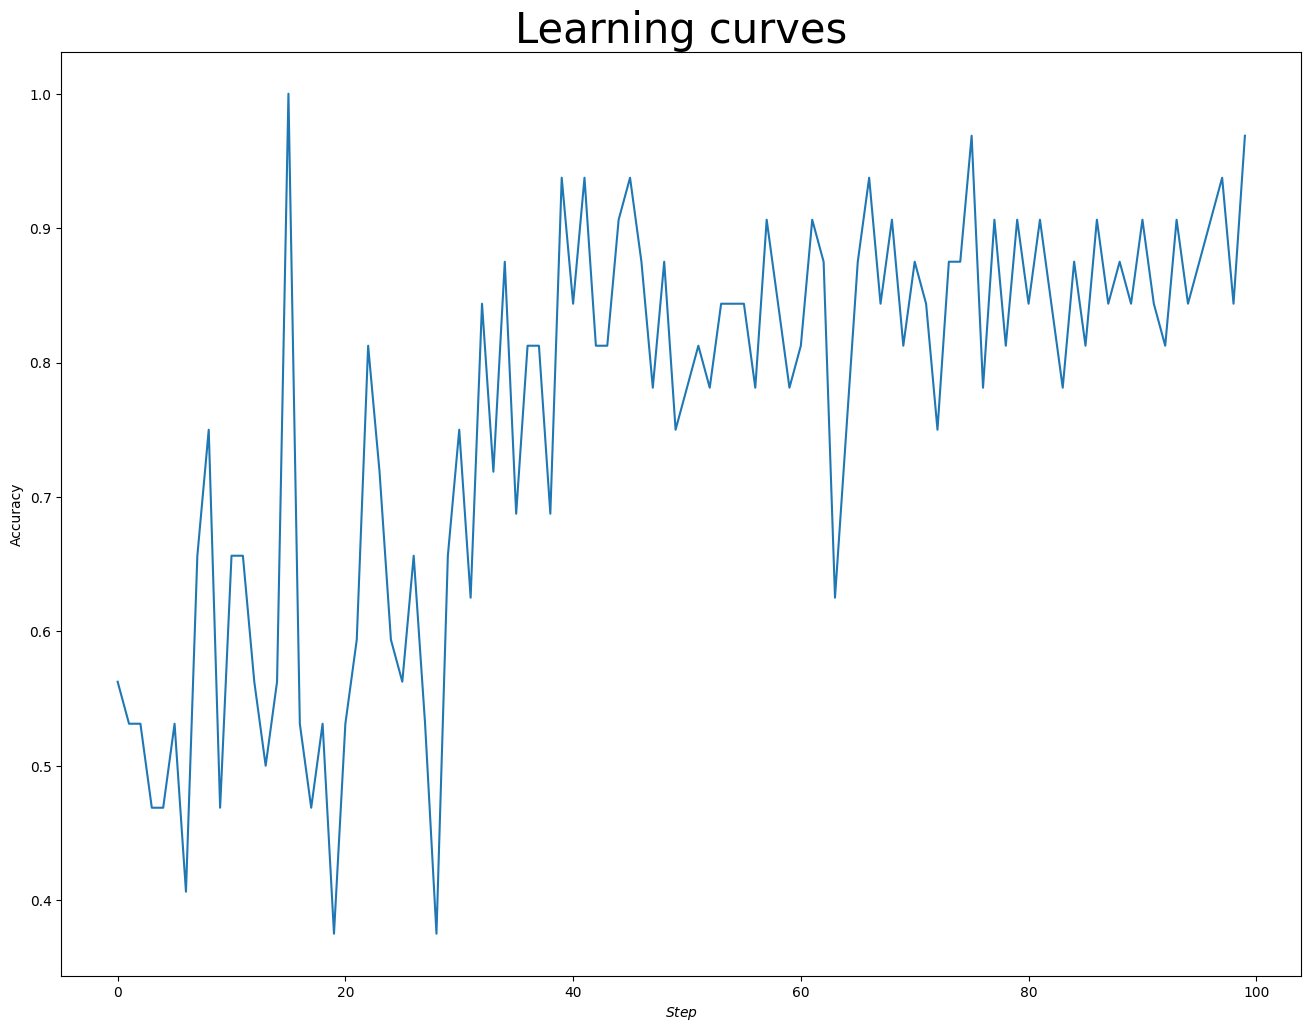

In [34]:
params_values, ch, ah = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, 1000, 0.01, batch_size=64, verbose=True)

plot_metric(ah, 'Accuracy')